In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
import sys
sys.path.append(r'c:\Users\ice\projects\iris')

from PIL import Image
import plotly.graph_objects as go
from IPython.display import display, HTML
import base64
from io import BytesIO

from iris.utils.data_utils import display_product_summary
from iris.config.data_pipeline_config_manager import DataPipelineConfigManager
from iris.config.embedding_pipeline_config_manager import EmbeddingPipelineConfigManager
from iris.data_pipeline.mongodb_manager import MongoDBManager
from iris.embedding_pipeline.embedding_handler import EmbeddingHandler
from iris.embedding_pipeline.embedding_database import EmbeddingDatabase

In [3]:
# Initialize configuration managers
data_config = DataPipelineConfigManager()
embedding_config = EmbeddingPipelineConfigManager()

shop_config = data_config.shop_configs["nikolaj_storm"]  # Select shop
mongodb_config = data_config.mongodb_config

# Create MongoDB manager
mongodb_manager = MongoDBManager(shop_config, mongodb_config)

# Initialize the EmbeddingHandler and Database
embedding_handler = EmbeddingHandler(embedding_config.clip_config)
embedding_db = EmbeddingDatabase(embedding_config.database_config, shop_config)
embedding_db.load()

In [4]:
# Convert cursor to list since it can only be iterated once
image_dataset = list(mongodb_manager.get_collection(
    mongodb_manager.mongodb_config.image_metadata_collection
).find())

In [5]:
# Get the query hash's index and embedding
query_hash = '3068271dd98042007498c8ee1a4604dc'

# Find index of the query hash in the database
hash_index = embedding_db.ids.index(query_hash)
query_embedding = embedding_db.embeddings[hash_index]

# Search for nearest neighbors
results = embedding_db.search(query_embedding, k=50)
print("Nearest neighbors for query hash", query_hash, ":", results)

Nearest neighbors for query hash 3068271dd98042007498c8ee1a4604dc : [('3068271dd98042007498c8ee1a4604dc', np.float32(0.0)), ('1beed0b36b23787418077082c8aaebc0', np.float32(0.04849722)), ('35545aa75006fd75fcc319b4e8101c62', np.float32(0.09309691)), ('d9c2c03d6d11bef798c4f39db53662ab', np.float32(0.10483335)), ('f8ec0ae6c24a85c447de21281a744f25', np.float32(0.10573311)), ('5db2628dbed833a2cacc87794c4f5ff1', np.float32(0.11085871)), ('96910e8d326a336156f6e41b073eaa14', np.float32(0.11358859)), ('e29199bdaf5b6c1e3387111a84c6f3f0', np.float32(0.115426436)), ('099b46b74e1aaf909fab35ab6bd12557', np.float32(0.11767364)), ('40ac3a71895fd38c6be161a5cfe17a90', np.float32(0.1250219)), ('72ca0e5f335685e6417b0bd050975e90', np.float32(0.12611161)), ('ba29578fadacd32b111bd808d86975ca', np.float32(0.13341409)), ('2f0153d141e4fc668c6c7ee4c360b322', np.float32(0.13439974)), ('16cd0bb97e51fff62153899466f1efd3', np.float32(0.13580829)), ('00d81a74570ffb3658120ef06143d9a6', np.float32(0.13817692)), ('dfa63e

In [22]:
def get_hash_source(hash_val):
    """Get source data for a hash (either image path or localization data)"""
    # First check if it's a regular image hash
    for data in image_dataset:
        if data['image_hash'] == hash_val:
            return {'type': 'image', 'image_data': data}
        # Then check if it's a localization hash
        if 'localizations' in data:
            for localization in data['localizations']:
                if localization['localization_hash'] == hash_val:
                    return {'type': 'localization', 'localization_data': localization, 'parent_image': data}
    return None

def get_image_html(source, size=(100, 140)):
    """Create HTML img tag for either an image path or localization data"""
    if source['type'] == 'image':
        image_data = source['image_data']
        with Image.open(image_data['local_path']) as img:
            img.thumbnail(size)
            buffered = BytesIO()
            img.save(buffered, format='JPEG', quality=70)
            img_b64 = base64.b64encode(buffered.getvalue()).decode()
            return f'<img src="data:image/jpeg;base64,{img_b64}" style="max-width:none">'
    else:  # localization
        localization_data = source['localization_data']
        parent_data = source['parent_image']
        
        # Get bounding box from original image
        with Image.open(parent_data['local_path']) as img:
            # Convert relative bbox coordinates to absolute pixels
            width, height = img.size
            bbox = localization_data['bbox']  # [x, y, width, height] in relative coords
            abs_bbox = [
                int(bbox[0] * width),      # x
                int(bbox[1] * height),     # y
                int(bbox[2] * width),      # width
                int(bbox[3] * height)      # height
            ]
            bbox_img = img.crop((
                abs_bbox[0],
                abs_bbox[1], 
                abs_bbox[0] + abs_bbox[2], 
                abs_bbox[1] + abs_bbox[3]
            ))
            bbox_img.thumbnail(size)
            
            buffered = BytesIO()
            bbox_img.save(buffered, format='JPEG', quality=70)
            img_b64 = base64.b64encode(buffered.getvalue()).decode()
            return f'<img src="data:image/jpeg;base64,{img_b64}" style="max-width:none">'

Suggested cutoff at index 5 (distance: 0.1109)



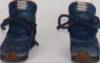
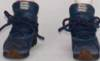
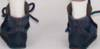
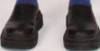
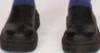
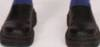
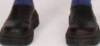
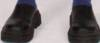
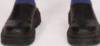
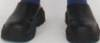
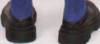
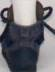
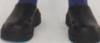
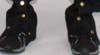
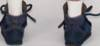
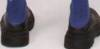
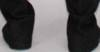
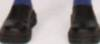
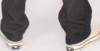
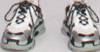
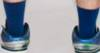
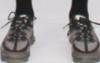
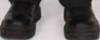
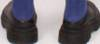
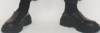
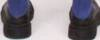
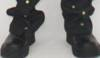
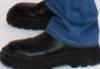
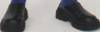
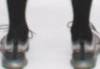
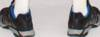
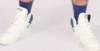
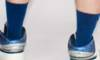
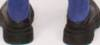
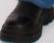
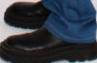
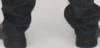
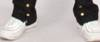
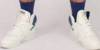
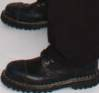
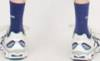
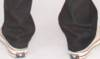
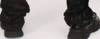
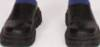
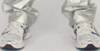
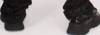
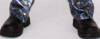
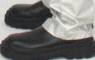

In [23]:
import numpy as np
from scipy.signal import savgol_filter

def find_distance_cutoff(distances, window=7, poly=2, base_std_multiplier=2.0, min_points=5):
    """Find cutoff point where distances start deviating significantly from the local trend.

    Args:
        distances: List of distances from nearest neighbor search
        window: Window size for smoothing (must be odd)
        poly: Polynomial order for smoothing
        base_std_multiplier: How many standard deviations to use for threshold
        min_points: Minimum number of points to return

    Returns:
        index: Cutoff index
    """
    distances = np.array(distances)
    
    # First smooth the distances to reduce noise
    smoothed = savgol_filter(distances, window, poly)
    
    # Calculate rolling statistics
    rolling_mean = [np.mean(smoothed[max(0, i-window):i+1]) 
                   for i in range(len(smoothed))]
    rolling_std = [np.std(smoothed[max(0, i-window):i+1])
                  for i in range(len(smoothed))]
    
    # Get baseline statistics from first few points
    base_mean = np.mean(smoothed[:min_points])
    base_std = np.std(smoothed[:min_points])
    
    # Find where distance exceeds mean + std threshold
    threshold = base_mean + (base_std * base_std_multiplier)

    # Look for consistent deviation
    cutoff_candidates = []
    for i in range(min_points, len(smoothed)):
        # Check if point and next few points exceed threshold
        if (smoothed[i] > threshold and
            smoothed[i] > rolling_mean[i] + rolling_std[i] * base_std_multiplier):
            cutoff_candidates.append(i)
            if len(cutoff_candidates) >= 3:  # Require multiple points above threshold
                return cutoff_candidates[0]
    
    # If no clear cutoff found, return minimum valid size
    return min_points

# Get distances from your results
distances = [dist for _, dist in results]
cutoff_idx = find_distance_cutoff(distances)

# Plot results
print(f"Suggested cutoff at index {cutoff_idx} (distance: {distances[cutoff_idx]:.4f})")

fig = go.Figure()

# Original distances
fig.add_trace(go.Scatter(
    x=list(range(len(distances))),
    y=distances,
    name='Distances',
    line=dict(color='blue')
))

# Add smoothed trace
smoothed = savgol_filter(distances, 7, 2)
fig.add_trace(go.Scatter(
    x=list(range(len(smoothed))),
    y=smoothed,
    name='Smoothed',
    line=dict(color='red', dash='dash')
))

# Highlight cutoff
fig.add_vline(
    x=cutoff_idx,
    line_dash="dash",
    line_color="green",
    annotation_text=f"Cutoff at {cutoff_idx}"
)

fig.update_layout(
    title='Distance Distribution with Cutoff',
    xaxis_title='Index',
    yaxis_title='Distance',
    width=1000,
    height=500,
    showlegend=True
)

fig.show()

# Show all images, with cutoff ones in red
html = ['<div style="display: flex; flex-wrap: wrap; gap: 10px;">']

for i, (hash_val, dist) in enumerate(results):
    source = get_hash_source(hash_val)
    if source is None:
        continue

    img_html = get_image_html(source)
    # Add red text and ❌ for items after cutoff
    text_color = 'color: red;' if i >= cutoff_idx else ''
    cutoff_marker = '❌ ' if i >= cutoff_idx else ''
    item_html = f"""
    <div style='text-align: center; border: 1px solid #ddd; padding: 5px;'>
        {img_html}
        <br>
        <small style='{text_color}'>{cutoff_marker}Index: {i}</small><br>
        <small style='{text_color}'>Distance: {dist:.4f}</small><br>
        <small style='{text_color}'>Hash: {hash_val}</small>
        <small style='{text_color}'>{'(Localization)' if source['type'] == 'localization' else ''}</small>
    </div>
    """
    html.append(item_html)

html.append('</div>')
display(HTML(''.join(html)))

Related products (in order of relevance):
--------------------------------------------------
Top Product: 90s Boxer – Upstormed (Score: 35.35)



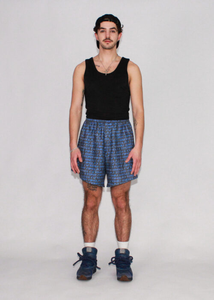
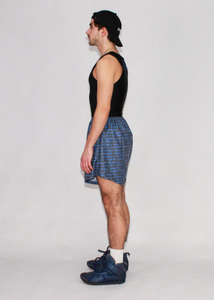
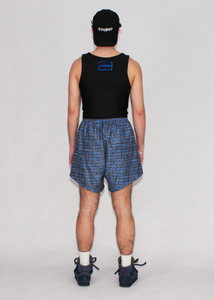

--------------------------------------------------


In [24]:
import plotly.express as px

# Get product scores using weighted distances for all images
scores = {}
product_titles = {}  # Store product titles for reference
title_counts = {}    # Track duplicate titles

# Get product collection reference
product_collection = mongodb_manager.get_collection(mongodb_manager.mongodb_config.product_collection)

# First get the source product of the query image
query_source = get_hash_source(query_hash)
query_product_hash = query_source['parent_image']['source_product'] if query_source['type'] == 'localization' else query_source['image_data']['source_product']

# Skip first result (index 0) since it's the query image itself
for (hash_val, dist) in results[1:]:
    source = get_hash_source(hash_val)
    if source is None:
        continue

    # Get product ID from parent image
    if source['type'] == 'localization':
        product_hash = source['parent_image']['source_product']
    else:
        product_hash = source['image_data']['source_product']

    # Get product title if not already stored
    if product_hash not in product_titles:
        product = product_collection.find_one({'product_hash': product_hash})
        title = product['title'] if product else 'Unknown Product'
        # Track duplicate titles
        title_counts[title] = title_counts.get(title, 0) + 1
        # Add hash suffix for duplicates
        if title_counts[title] > 1:
            title = f"{title} ({product_hash[:6]}...)"
        product_titles[product_hash] = title

    # Use inverse distance as weight (add small epsilon to avoid division by zero)
    weight = 1.0 / (dist + 1e-6)
    scores[product_hash] = scores.get(product_hash, 0.0) + weight

# Sort products by score
sorted_products = sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Create bar colors array - highlight original product
colors = ['red' if hash_val == query_product_hash else 'lightblue' 
         for hash_val, _ in sorted_products]

# Create vertical bar chart of product scores using titles
fig = go.Figure(data=[
    go.Bar(
        y=[score for _, score in sorted_products],
        x=[product_titles[hash_val][:40] + ('...' if len(product_titles[hash_val])>40 else '') for hash_val, _ in sorted_products],
        text=[f'{score:.2f}' for _, score in sorted_products],
        textposition='auto',
        marker_color=colors
    )
])

fig.update_layout(
    title='Product Relevance Scores (Red = Query Product)',
    yaxis_title='Score',
    xaxis_title='Product Title',
    width=800,
    height=500,
    showlegend=False,
    xaxis=dict(
        tickangle=45,  # Angle the labels for better readability
        showgrid=True
    )
)

fig.show()

print("Related products (in order of relevance):")
print("-" * 50)

# Display top product using plot_product_summary
if sorted_products:
    top_product_hash = sorted_products[0][0]
    print(f"Top Product: {product_titles[top_product_hash]} (Score: {sorted_products[0][1]:.2f})")
    display_product_summary(mongodb_manager, top_product_hash)

print("-" * 50)

In [27]:
# Update MongoDB with localization point and product hash
# Get the parent image hash from query source
parent_image_hash = query_source['parent_image']['image_hash']

# Sort predictions by score and create ordered dict
product_predictions = {
    product_hash: float(score)  # Convert numpy float32 to Python float
    for product_hash, score in sorted_products
}

# Get the point coordinates from the query source
bbox = query_source['localization_data']['bbox']
point_coords = (
    bbox[0] + bbox[2] / 2,  # x coordinate (center of the bounding box)
    bbox[1] + bbox[3] / 2   # y coordinate (center of the bounding box)
)

# Prepare the update for the localization in the image document
filter_query = {
    'image_hash': parent_image_hash,
    'localizations.localization_hash': query_source['localization_data']['localization_hash']
}

# Create the update data
update_data = {
    'localizations.$.localization_point': {
        'x': float(point_coords[0]),
        'y': float(point_coords[1])
    },
    'localizations.$.product_hash': top_product_hash,
    'localizations.$.product_predictions': product_predictions
}

# Update the document
success = mongodb_manager.update_one(
    mongodb_manager.mongodb_config.image_metadata_collection,
    filter_query,
    update_data,
    upsert=False
)

print(f"Database update {'successful' if success else 'failed'}")

# Verify the update by retrieving the document
updated_doc = mongodb_manager.find_one(
    mongodb_manager.mongodb_config.image_metadata_collection,
    {'image_hash': parent_image_hash}
)

if updated_doc:
    for localization in updated_doc['localizations']:
        if localization['localization_hash'] == query_source['localization_data']['localization_hash']:
            print("\nUpdated localization data:")
            print(f"Localization hash: {localization['localization_hash']}")
            print(f"Point coordinates: {localization.get('localization_point', 'Not set')}")
            print("\nTop 5 product predictions:")
            for i, (prod_hash, score) in enumerate(localization.get('product_predictions', {}).items()):
                if i >= 5: break
                title = product_titles.get(prod_hash, 'Unknown Product')
                print(f"{title}: {score:.2f}")
else:
    print("Could not retrieve updated document")

Database update successful

Updated localization data:
Localization hash: 3068271dd98042007498c8ee1a4604dc
Point coordinates: {'x': 0.4916493147611618, 'y': 0.879006564617157}

Top 5 product predictions:
90s Boxer – Upstormed: 35.35
Gordito Tee – Sample: 15.95
Danny Jacket: 15.83
Track Jacket: 14.89
Yumbo Shirt: 14.80
